# Automate XPCS

In [1]:
from globus_automate_client import (create_flows_client, graphviz_format, state_colors_for_log,
                                    get_access_token_for_scope, create_action_client, 
                                    create_flows_client)
from IPython.display import display, display_svg, clear_output
from ipywidgets import widgets
import time
import json
import sys
import os

from funcx.sdk.client import FuncXClient


import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  


sys.path.append(".")
os.environ['JUPYTER_PATH'] = '.'
CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"

In [2]:
# Set up a database to record experiments
import sqlite3
conn = sqlite3.connect('xpcs_exp.db')
cur = conn.cursor()


cur.execute('''CREATE TABLE if not exists configs
             (id INTEGER PRIMARY KEY AUTOINCREMENT, flow_id text, flow_scope, fx_corr, fx_plot, fx_pilot, login_ep, theta_ep, tag) ''')

cur.execute('''CREATE TABLE if not exists experiments
             (id INTEGER PRIMARY KEY AUTOINCREMENT, config integer, action_id text, start DATETIME, end DATETIME, tag) ''')
conn.commit()

## funcX

Deine the analysis and plotting functions used in the flow.

In [3]:
fxc = FuncXClient()

In [4]:
login_ep = '6c4323f4-a062-4551-a883-146a352a43f5'
theta_ep = '9f84f41e-dfb6-4633-97be-b46901e9384c'
theta_30_ep = 'ab9abc3e-9595-4eae-99f3-fac5c7f6282e'
# local_ep = '4a308ac0-1b73-4196-8a7d-792427901f0f'

In [5]:
def alcf_xpcs_corr(event):
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Corr")
    
    hdf_file = event['data']['hdf']
    imm_file = event['data']['imm']
    
    flags = ""
    if "flags" in event['data']:
        flags = event['data']
    
    cmd = f"/soft/datascience/xpcs_eigen/build/corr {hdf_file} -imm {imm_file} {flags}"
    cmd = cmd.strip().split(" ")
    
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

alcf_xpcs_corr_func_uuid = fxc.register_function(alcf_xpcs_corr, description="An XPCS corr function.")
print(alcf_xpcs_corr_func_uuid)

8540f6fc-f766-4fc0-9547-dc6e6d1dd7f0


In [6]:
def plot_xpcs(event):
    import os
    import time
    import json
    import shutil
    import pickle
    import subprocess
    from subprocess import PIPE
    
    hdf_file = event['data']['hdf']
    hdf_file_name = hdf_file.split("/")[-1]
    exp_name = ".".join(hdf_file.split("/")[-1].split(".")[:-1])
    
    dir_name = "/".join(hdf_file.split('/')[:-1])

    os.chdir(dir_name)
    
    python = '/home/rchard/.conda/envs/funcx-theta/bin/python'
    xpcs_plot = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_plots.py'
    xpcs_meta = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_metadata.py'
    xpcs_qc = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_qc.py'

    cmd = f"{python} {xpcs_plot} {hdf_file}"
    print(cmd)
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    
    cmd = f"{python} {xpcs_meta} gather {hdf_file}"
    print(cmd)
    
    my_env = os.environ.copy()
    my_env["LC_ALL"] = "C.UTF-8"
    my_env["LANG"] = "C.UTF-8"
    
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE, env=my_env)
    print(res.stdout)
    print(res.stderr) 

    return cmd
    return 'done'

plot_xpcs_func_uuid = fxc.register_function(plot_xpcs, description="An XPCS corr function.")
print(plot_xpcs_func_uuid)

e6af6111-ad3f-404e-a68c-229496075681


In [7]:
def alcf_xpcs_pilot(event):
    import os
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Pilot")
    
    meta_file = event['data']['metadata']
    exp_dir = "/".join(event['data']['hdf'].split("/")[:-2])
    exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")
    os.chdir(exp_dir)
    
    pilot = '/home/rchard/.conda/envs/funcx-theta/bin/pilot'

    cmd = f"{pilot} upload -u -j {meta_file} {exp_name} /"
    print(cmd)

    res = subprocess.run(cmd.split(" "), stdout=PIPE, stderr=PIPE,
    env={'LC_ALL': 'C.UTF-8', 'LANG': 'C.UTF-8'})
    
    print(res.stdout)
    return str(res.stdout)

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

c1314fac-7f59-40d6-8aa8-700df84d64b6


# Evaluation

Compare the performance of different flows, inputs, and compute resources.

## Flow 1: XPCS Corr

In [18]:
# Run XPCS Corr and return the result. Doesn't plot or use Pilot.

flow_definition = {
  "Comment": "Automate XPCS",
  "StartAt": "Transfer1",
  "States": {
    "Transfer1": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer1Input",
      "ResultPath": "$.Transfer1Result",
      "WaitTime": 6000,
      "Next": "ExecCorr"
    },
    "ExecCorr": {
      "Comment": "Use corr to process the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 12000,
      "Next": "Transfer2"
    },
    "Transfer2": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer2Input",
      "ResultPath": "$.Transfer2Result",
      "WaitTime": 6000,
      "End": True
    }
  }
}

In [19]:
flows_client = create_flows_client(CLIENT_ID)
flow = flows_client.deploy_flow(flow_definition, title="XPCS")
from pprint import pprint
pprint(flow)
flow_id = flow.data['id']
print(flow)
flow_scope = flow['globus_auth_scope']
print(f'Newly created flow with id:\n{flow_id}\nand scope:\n{flow_scope}')

GlobusHTTPResponse({'administered_by': [], 'api_version': '1.0', 'definition': {'Comment': 'Automate XPCS', 'StartAt': 'Transfer1', 'States': {'ExecCorr': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://funcx.org/automate', 'Comment': 'Use corr to process the data', 'InputPath': '$.Exec1Input', 'Next': 'Transfer2', 'ResultPath': '$.Exec1Result', 'Type': 'Action', 'WaitTime': 12000}, 'Transfer1': {'ActionScope': 'https://auth.globus.org/scopes/actions.globus.org/transfer/transfer', 'ActionUrl': 'https://actions.automate.globus.org/transfer/transfer', 'Comment': 'Initial Transfer from APS to ALCF', 'InputPath': '$.Transfer1Input', 'Next': 'ExecCorr', 'ResultPath': '$.Transfer1Result', 'Type': 'Action', 'WaitTime': 6000}, 'Transfer2': {'ActionScope': 'https://auth.globus.org/scopes/actions.globus.org/transfer/transfer', 'ActionUrl': 'https://actions.automate.globus.org/transfer/transfer', 'Comment': 'Initial Transfer f

Store things in the database to track this experiment

In [20]:
# Store this config as an experiment definition so we can track what was used.

print(flow_id)
print(flow_scope)
print(alcf_xpcs_corr_func_uuid)
print(plot_xpcs_func_uuid)
print(pilot_func_uuid)

tag = 'test'

cmd = f"insert into configs (flow_id, flow_scope, fx_corr, fx_plot, fx_pilot, login_ep, theta_ep, tag) " \
      f"values ('{flow_id}', '{flow_scope}', '{alcf_xpcs_corr_func_uuid}', '{plot_xpcs_func_uuid}', '{pilot_func_uuid}', '{login_ep}', '{theta_ep}', '{tag}');"

cur.execute(cmd)
conn.commit()
config_id = cur.lastrowid
print(config_id)

0175c296-8d6f-4d0d-b4e7-27f11b4eace6
https://auth.globus.org/scopes/0175c296-8d6f-4d0d-b4e7-27f11b4eace6/flow_0175c296_8d6f_4d0d_b4e7_27f11b4eace6
8540f6fc-f766-4fc0-9547-dc6e6d1dd7f0
e6af6111-ad3f-404e-a68c-229496075681
c1314fac-7f59-40d6-8aa8-700df84d64b6
3


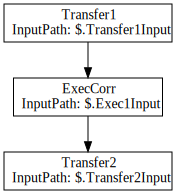

In [21]:
get_resp = flows_client.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

Define a function to serialize inputs for funcX

In [22]:
def serialize_fx_inputs(*args, **kwargs):
    from funcx.serialize import FuncXSerializer
    fx_serializer = FuncXSerializer()
    ser_args = fx_serializer.serialize(args)
    ser_kwargs = fx_serializer.serialize(kwargs)
    payload = fx_serializer.pack_buffers([ser_args, ser_kwargs])
    return payload

In [23]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/test/test.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/test/test.imm",
#          "flags": "--rigaku",     
         "metadata": "/projects/APSDataAnalysis/Automate/test/test.json"      
     }}
funcx_payload = serialize_fx_inputs(event=event)
# print(funcx_payload)

In [24]:
# A real dataset from Suresh

# "Transfer1Input": {
#       "source_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
#       "destination_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
#       "transfer_items": [
#         {
#           "source_path": "/data/xpcs8/2019-3/sanat201911/cluster_results/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768.hdf",
#           "destination_path": "/projects/APSDataAnalysis/Automate/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768.hdf",
#           "recursive": false
#         },
#         {
#           "source_path": "/data/xpcs8/2019-3/sanat201911/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_00001-00768.imm",
#           "destination_path": "/projects/APSDataAnalysis/Automate/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_00001-00768.imm",
#           "recursive": false
#         }
#       ]
#     },
#     "Exec1Input": {
#       "endpoint": "9f84f41e-dfb6-4633-97be-b46901e9384c",
#       "func": "9460c8b8-0d72-483a-9fa4-2a3c39d762b1",
#       "payload": "12\n01\ngAMpLg==\n688\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWIgAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQw\nQ19McTBfMDAxXzAwMDItMDc2OC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAw\nMV8wMDAyLTA3NjguaGRmcQZYAwAAAGltbXEHWIoAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lz\nL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQwQ19McTBfMDAxXzAwMDItMDc2\nOC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAwMS0wMDc2OC5pbW1x\nCFgIAAAAbWV0YWRhdGFxCViJAAAAL3Byb2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS9B\nMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAyLTA3NjgvQTAxMV9NSl9Q\nTUFfNDdnMjlrRGFfYXR0Ml8xNDBDX0xxMF8wMDFfMDAwMi0wNzY4Lmpzb25xCnVzcy4=\n"
#     },
#     "Exec2Input": {
#       "endpoint": "9f84f41e-dfb6-4633-97be-b46901e9384c",
#       "func": "7bf3891a-a23d-40dc-a218-236964cf3963",
#       "payload": "12\n01\ngAMpLg==\n688\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWIgAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQw\nQ19McTBfMDAxXzAwMDItMDc2OC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAw\nMV8wMDAyLTA3NjguaGRmcQZYAwAAAGltbXEHWIoAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lz\nL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQwQ19McTBfMDAxXzAwMDItMDc2\nOC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAwMS0wMDc2OC5pbW1x\nCFgIAAAAbWV0YWRhdGFxCViJAAAAL3Byb2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS9B\nMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAyLTA3NjgvQTAxMV9NSl9Q\nTUFfNDdnMjlrRGFfYXR0Ml8xNDBDX0xxMF8wMDFfMDAwMi0wNzY4Lmpzb25xCnVzcy4=\n"
#     },
#     "Exec3Input": {
#       "endpoint": "6c4323f4-a062-4551-a883-146a352a43f5",
#       "func": "a0c5efbc-a73c-464f-b80b-353f14cdf3dc",
#       "payload": "12\n01\ngAMpLg==\n688\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWIgAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQw\nQ19McTBfMDAxXzAwMDItMDc2OC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAw\nMV8wMDAyLTA3NjguaGRmcQZYAwAAAGltbXEHWIoAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lz\nL0F1dG9tYXRlL0EwMTFfTUpfUE1BXzQ3ZzI5a0RhX2F0dDJfMTQwQ19McTBfMDAxXzAwMDItMDc2\nOC9BMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAwMS0wMDc2OC5pbW1x\nCFgIAAAAbWV0YWRhdGFxCViJAAAAL3Byb2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS9B\nMDExX01KX1BNQV80N2cyOWtEYV9hdHQyXzE0MENfTHEwXzAwMV8wMDAyLTA3NjgvQTAxMV9NSl9Q\nTUFfNDdnMjlrRGFfYXR0Ml8xNDBDX0xxMF8wMDFfMDAwMi0wNzY4Lmpzb25xCnVzcy4=\n"
#     },
#     "Transfer2Input": {
#       "source_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
#       "destination_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
#       "transfer_items": [
#         {
#           "source_path": "/projects/APSDataAnalysis/Automate/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768.hdf",
#           "destination_path": "/data/xpcs8/2019-3/sanat201911/ALCF_results/A011_MJ_PMA_47g29kDa_att2_140C_Lq0_001_0002-0768.hdf",
#           "recursive": false
#         }
#       ]
#     }
#   },

In [25]:
flow_input = {
  "Transfer1Input": {
    "source_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
    "destination_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
    "transfer_items": [
      {
        "source_path": "/data/xpcs8/2019-3/sanat201911/cluster_results/A008_MJ_PMA_47g80kDa_att2_180C_Lq0_004_0002-0400.hdf",
        "destination_path": event['data']['hdf'],
        "recursive": False
      },
      {
        "source_path": "/data/xpcs8/2019-3/sanat201911/A008_MJ_PMA_47g80kDa_att2_180C_Lq0_004/A008_MJ_PMA_47g80kDa_att2_180C_Lq0_004_00001-00400.imm",
        "destination_path": event['data']['imm'],
        "recursive": False
      }
    ]
  },
  "Exec1Input": {
    "endpoint":theta_30_ep,
     "func":alcf_xpcs_corr_func_uuid,
     "payload": funcx_payload
  },
  "Exec2Input": {
    "endpoint":theta_ep,
     "func":plot_xpcs_func_uuid,
     "payload": funcx_payload
  },
  "Exec3Input": {
      "endpoint": login_ep,
      "func": pilot_func_uuid,
      "payload": funcx_payload
  },
    "Transfer2Input": {
      "source_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
      "destination_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
      "transfer_items": [
        {
          "source_path": event['data']['hdf'],
          "destination_path": "/data/xpcs8/2019-1/comm201901/ALCF_results/test.hdf",
          "recursive": False
        }
      ]
    }
}


In [26]:
flow_action = flows_client.run_flow(flow_id, flow_scope, flow_input)
print(flow_action)
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']
print(f'Flow action started with id: {flow_action_id}')
while flow_status == 'ACTIVE':
    time.sleep(10)
    flow_action = flows_client.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

Login Here:

https://auth.globus.org/v2/oauth2/authorize?client_id=e6c75d97-532a-4c88-b031-8584a319fa3e&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=https%3A%2F%2Fauth.globus.org%2Fscopes%2F0175c296-8d6f-4d0d-b4e7-27f11b4eace6%2Fflow_0175c296_8d6f_4d0d_b4e7_27f11b4eace6&state=_default&response_type=code&code_challenge=iMY7myvGJuQt2VNULBpVabpEkIwuHlMaIJdTb1QV0Uo&code_challenge_method=S256&access_type=offline&prefill_named_grant=Globus+Automate+Client


Note that this link can only be used once! If login or a later step in the flow fails, you must restart it.
Enter resulting code:2Lshnl1hhkTdnr2jDgUuwmcdzKHjsA
GlobusHTTPResponse({'action_id': 'c1e757b0-fcbd-4fc8-86d0-70a417d26b75', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State Transfer1 of type Action started', 'details': {'input': {'Exec1Input': {'endpoint': 'ab9abc3e-9595-4eae-99f3-fac5c7f628

In [183]:
flow_action

GlobusHTTPResponse({'action_id': '803e65b3-662f-487a-8be7-07555b7f9373', 'completion_time': '2020-01-22T00:30:46.070000+00:00', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'output': {'Exec1Input': {'endpoint': 'ab9abc3e-9595-4eae-99f3-fac5c7f6282e', 'func': '9d63bf59-114b-4de4-92b6-b88c97898ec6', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDAAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVzdC5oZGZxBlgDAAAAaW1tcQdYMAAA\nAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMvQXV0b21hdGUvdGVzdC90ZXN0LmltbXEIWAgAAABt\nZXRhZGF0YXEJWDEAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVz\ndC5qc29ucQp1c3Mu\n'}, 'Exec1Result': {'action_id': '6faf0e23-56e1-49c5-b286-aaa3cd08b02f', 'details': {'completion_t': 1579653033.2178738, 'result': '01\ngANYBwMAAGInWzIwMjAtMDEtMjIgMDA6Mjk6MTYuMjQwXSBbY29uc29sZV0gW2luZm9dIEg1IG1l\ndGFkYXRhIHBhdGggL3hwY3NcblsyMDIwLTAxLTIyIDAwOjI5OjE2LjYzM10gW2NvbnNvbGVd

In [184]:
# Run time info
print(flow_action['start_time'])
print(flow_action['completion_time'])

# Transfer info
flow_action['details']['output']['Transfer1Result']['details']['task_id']

2020-01-22T00:27:27.613000+00:00
2020-01-22T00:30:46.070000+00:00


'f9713264-3cad-11ea-ab4c-0a7959ea6081'

In [185]:
results.append({flow_action['action_id']: {'start': flow_action['start_time'], 'stop': flow_action['completion_time']}})

Repeat the test to hopefully get a shorter period of time

In [186]:
flow_action = flows_client.run_flow(flow_id, flow_scope, flow_input)
print(flow_action)
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']
print(f'Flow action started with id: {flow_action_id}')
while flow_status == 'ACTIVE':
    time.sleep(10)
    flow_action = flows_client.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

GlobusHTTPResponse({'action_id': '0c800086-4dc6-4bed-b5e5-32bcaaceec45', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State Transfer1 of type Action started', 'details': {'input': {'Exec1Input': {'endpoint': 'ab9abc3e-9595-4eae-99f3-fac5c7f6282e', 'func': '9d63bf59-114b-4de4-92b6-b88c97898ec6', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDAAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVzdC5oZGZxBlgDAAAAaW1tcQdYMAAA\nAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMvQXV0b21hdGUvdGVzdC90ZXN0LmltbXEIWAgAAABt\nZXRhZGF0YXEJWDEAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVz\ndC5qc29ucQp1c3Mu\n'}, 'Exec2Input': {'endpoint': '9f84f41e-dfb6-4633-97be-b46901e9384c', 'func': '8bb88ffa-a240-4433-9cd0-237f37def8fa', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDA

In [187]:
results.append({flow_action['action_id']: {'start': flow_action['start_time'], 'stop': flow_action['completion_time']}})

In [188]:
# Run time info
print(flow_action['start_time'])
print(flow_action['completion_time'])

2020-01-22T00:30:51.193000+00:00
2020-01-22T00:32:31.821000+00:00


# Plotting

List out the invocations of this flow

In [84]:
fc = flows_client
flow_runs = fc.list_flow_actions(flow_id, flow_scope, statuses=None)

Check one of them to see what it looks like.

In [85]:
# print(len(flow_runs['actions']))
print(flow_runs['actions'][0])

{'action_id': '367a61bf-63d0-4d57-9b74-f3b9d7b2461c', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State Transfer1 of type Action started', 'details': {'input': {'Exec1Input': {'endpoint': 'ab9abc3e-9595-4eae-99f3-fac5c7f6282e', 'func': '9d63bf59-114b-4de4-92b6-b88c97898ec6', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDAAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVzdC5oZGZxBlgDAAAAaW1tcQdYMAAA\nAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMvQXV0b21hdGUvdGVzdC90ZXN0LmltbXEIWAgAAABt\nZXRhZGF0YXEJWDEAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVz\ndC5qc29ucQp1c3Mu\n'}, 'Exec2Input': {'endpoint': '9f84f41e-dfb6-4633-97be-b46901e9384c', 'func': '8bb88ffa-a240-4433-9cd0-237f37def8fa', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDAAAAAvcHJvamVj\ndHMv

In [86]:
# action_id = 'eecff227-a692-4fdd-835d-77595fd4e5e7'
action_id = flow_runs['actions'][0]['action_id']

Check the action logs for this flow

In [87]:
flow_log = fc.flow_action_log(flow_id, flow_scope, action_id)

In [88]:
flow_log

GlobusHTTPResponse({'entries': [{'code': 'FlowSucceeded', 'description': 'The Flow Instance completed successfully', 'details': {'output': {'Exec1Input': {'endpoint': 'ab9abc3e-9595-4eae-99f3-fac5c7f6282e', 'func': '9d63bf59-114b-4de4-92b6-b88c97898ec6', 'payload': '12\n01\ngAMpLg==\n328\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWDAAAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVzdC5oZGZxBlgDAAAAaW1tcQdYMAAA\nAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMvQXV0b21hdGUvdGVzdC90ZXN0LmltbXEIWAgAAABt\nZXRhZGF0YXEJWDEAAAAvcHJvamVjdHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL3Rlc3QvdGVz\ndC5qc29ucQp1c3Mu\n'}, 'Exec1Result': {'action_id': 'acb12387-b098-4a62-8509-4185d6e4d031', 'details': {'completion_t': 1579639732.6274486, 'result': '01\ngANYBQMAAGInWzIwMjAtMDEtMjEgMjA6NDY6MzIuNzU3XSBbY29uc29sZV0gW2luZm9dIEg1IG1l\ndGFkYXRhIHBhdGggL3hwY3NcblsyMDIwLTAxLTIxIDIwOjQ2OjMzLjEyOF0gW2NvbnNvbGVdIFtp\nbmZvXSBCdWlsZFFNYXAoKSB0b29rIDE5MSBtc1xuWzIwMjAtMDEtMjEgMjA6NDY6MzMuMTMxXSBb\nY29uc2

Hmm, it doesn't look like this one succeeded.

In [145]:
for l in flow_log['entries']:
    print(l['code'])
    if 'details' in l and 'state_name' in l['details']:
        print(l['details']['state_name'])
        if l['details']['state_name'] == 'Transfer1' and l['code'] == 'ActionCompleted':
            print('DONE')
          

FlowSucceeded
ActionCompleted
Transfer2
ActionPolled
Transfer2
ActionPolled
Transfer2
ActionCompleted
Transfer2
ActionFailed
ActionPolled
ExecCorr
ActionCompleted
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionPolled
ExecCorr
ActionCompleted
ExecCorr
ActionFailed
ActionPolled
Transfer1
ActionCompleted
Transfer1
DONE
ActionPolled
Transfer1
ActionPolled
Transfer1
ActionPolled
Transfer1
ActionPolled
Transfer1
ActionFailed
ActionStarted
Transfer1
FlowStarted


This one failed because I had too many concurrent transfers pending.

# Now grab it all into a dataframe

Iterate through all of them and pull out the successful ones. Then we can make a dataframe from their timestamps to see what they got up to.

In [90]:
flow_runs = fc.list_flow_actions(flow_id, flow_scope, statuses=None)

Grab all of the action ids so we can inspect them.

In [91]:
action_ids = []
for res in flow_runs['actions']:
    action_ids.append(res['action_id'])

Now do get each action id's log. This is time consuming.

In [92]:
flow_logs = {}
for aid in action_ids:
    flow_log = fc.flow_action_log(flow_id, flow_scope, aid, limit=100)
    flow_logs.update({aid: flow_log})
#     break

Filter for successful ones.

In [93]:
succeeded_flows = {}
for x, z in flow_logs.items():
    y = z['entries'][0]['code']
#     print(y)
    if 'Succeeded' in y:
        succeeded_flows[x] = z
#     break

In [94]:
print(len(succeeded_flows))

3


In [117]:
import datetime

order = ['Start', 'Transfer1', 'ExecCorr','Transfer2', 
#          'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 
         'End']

res = {}
for sf in succeeded_flows:
    tmp = succeeded_flows[sf]
    flow_end = None
    flow_start = float('inf')
    flow_start_time = None
    flow_steps = {}
    for x in tmp['entries']:
        action_timestamp = None
        try:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%f+00:00').timestamp()
        except:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S+00:00').timestamp()
        if action_timestamp < flow_start:
            flow_start = action_timestamp
            flow_start_time = action_timestamp
        if x['code'] == "FlowSucceeded":
            flow_end = action_timestamp
        if x['code'] == 'ActionCompleted':
            if 'details' in x and 'state_name' in x['details']:
                action_name = x['details']['state_name']
            action_time = action_timestamp
            flow_steps.update({action_name : action_time})
            # We can pull out transfer times/size here. Do that once this works and we want to include more info.
            
    #         if 'Transfer' in action_name or 'Stage' in action_name:
    #             print(action_name)
    #             print(x['details'])
    #             break
    flow_steps.update({"Start": flow_start, "End": flow_end})
    # Deal with the first transfer not existing due to max actions exceeded
    if 'Transfer1' not in flow_steps:
        flow_steps['Transfer1'] = flow_steps['Start']
    flow_times = [flow_steps['Start'], flow_steps['Transfer1'], flow_steps['Transfer2'], 
                  flow_steps['ExecCorr'], 
#                   flow_steps['ExecPlots'], flow_steps['StageToPetrel'], 
#                   flow_steps['StageImagesToPetrel'], 
                  flow_steps['End']]
    res[sf] = flow_times
#     print(flow_steps)
#     break


In [118]:
adf = pd.DataFrame.from_dict(res, orient='columns')
adf

,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,42b2574f-a2a6-4701-870e-a21de8896d68,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a
0,1.579661e+09,1.579661e+09,1.579660e+09
1,1.579661e+09,1.579661e+09,1.579660e+09
2,1.579661e+09,1.579662e+09,1.579661e+09
3,1.579661e+09,1.579661e+09,1.579660e+09
4,1.579661e+09,1.579662e+09,1.579661e+09


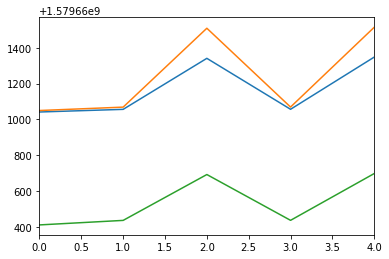

In [119]:
adf.plot(legend=None)

In [120]:
df = pd.DataFrame(res)

In [121]:
# df.groupby("Flow")

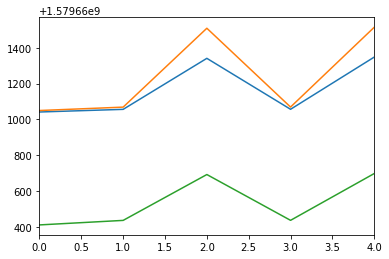

In [122]:
df.plot(legend=None)

In [123]:
import datetime

order = ['Start', 'Transfer1', 'ExecCorr', 'Transfer2',
#          'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 
         'End']

res3 = []
for sf in succeeded_flows:
    tmp = succeeded_flows[sf]
    flow_end = None
    flow_start = float('inf')
    flow_start_time = None
    flow_steps = {}
    for x in tmp['entries']:
        action_timestamp = None
        try:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%f+00:00').timestamp()
        except:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S+00:00').timestamp()
        if action_timestamp < flow_start:
            flow_start = action_timestamp
            flow_start_time = action_timestamp
        if x['code'] == "FlowSucceeded":
            flow_end = action_timestamp
        if x['code'] == 'ActionCompleted':
            if 'details' in x and 'state_name' in x['details']:
                action_name = x['details']['state_name']
            action_time = action_timestamp
            flow_steps.update({action_name : action_time})
            # We can pull out transfer times/size here. Do that once this works and we want to include more info.
            
    #         if 'Transfer' in action_name or 'Stage' in action_name:
    #             print(action_name)
    #             print(x['details'])
    #             break
    flow_steps.update({"Flow": sf, "Start": flow_start, "End": flow_end})
    time_res = [sf]
    for x in order:
        try:
            time_res.append(flow_steps[x])
        except:
            # Transfer1 might not be here if we have over 100 steps.
            time_res.append(flow_steps['Start'])
    res3.append(time_res)

In [124]:
adf = pd.DataFrame(res3, columns=['Flow', 'Start', 'Transfer1', 'ExecCorr', 'Transfer2',
#                                   'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 
                                  'End'])
adf2 = pd.DataFrame(res3, columns=['Flow', 1, 2, 3, 4, 
#                                    5, 6, 7,
                                   5])

In [125]:
adf2

,Flow,1,2,3,4,5
0,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,1.579661e+09,1.579661e+09,1.579661e+09,1.579661e+09,1.579661e+09
1,42b2574f-a2a6-4701-870e-a21de8896d68,1.579661e+09,1.579661e+09,1.579661e+09,1.579662e+09,1.579662e+09
2,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,1.579660e+09,1.579660e+09,1.579660e+09,1.579661e+09,1.579661e+09


In [126]:
df4=pd.melt(adf2,id_vars=['Flow'],var_name='metrics', value_name='values')
df4

,Flow,metrics,values
0,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,1,1.579661e+09
1,42b2574f-a2a6-4701-870e-a21de8896d68,1,1.579661e+09
2,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,1,1.579660e+09
3,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,2,1.579661e+09
4,42b2574f-a2a6-4701-870e-a21de8896d68,2,1.579661e+09
5,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,2,1.579660e+09
6,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,3,1.579661e+09
7,42b2574f-a2a6-4701-870e-a21de8896d68,3,1.579661e+09
8,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,3,1.579660e+09
9,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,4,1.579661e+09


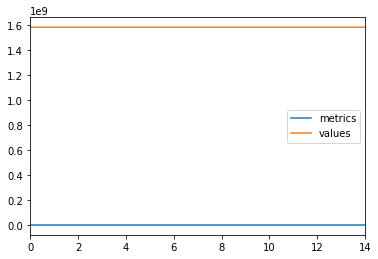

In [127]:
df4.plot(kind='line', label="Flow")

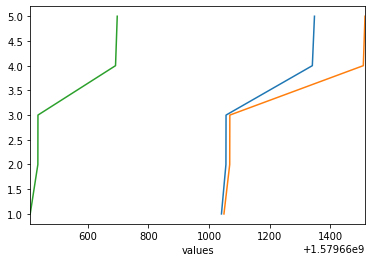

In [149]:
# df2.plot(kind='scatter', y='values', x='metrics')
fig, ax = plt.subplots()
df4.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
plt.show()

In [129]:
df4.to_csv('xpcs_melt_numeric.csv')

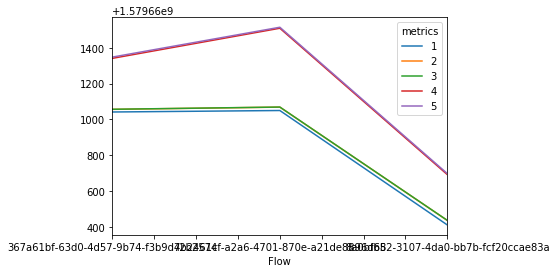

In [130]:

df3 = df4.pivot(index='Flow', columns='metrics', values='values')
# df3
df3.plot()

In [131]:
xdf = pd.read_csv('xpcs_melt_numeric.csv')

In [132]:
xdf

,Unnamed: 0,Flow,metrics,values
0,0,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,1,1.579661e+09
1,1,42b2574f-a2a6-4701-870e-a21de8896d68,1,1.579661e+09
2,2,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,1,1.579660e+09
3,3,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,2,1.579661e+09
4,4,42b2574f-a2a6-4701-870e-a21de8896d68,2,1.579661e+09
5,5,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,2,1.579660e+09
6,6,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,3,1.579661e+09
7,7,42b2574f-a2a6-4701-870e-a21de8896d68,3,1.579661e+09
8,8,8a0bfb52-3107-4da0-bb7b-fcf20ccae83a,3,1.579660e+09
9,9,367a61bf-63d0-4d57-9b74-f3b9d7b2461c,4,1.579661e+09


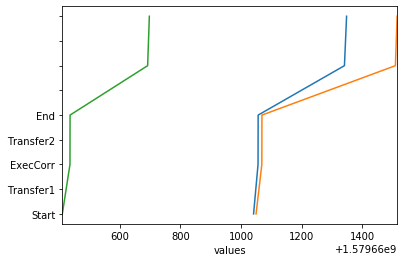

In [133]:
ticks = ['', 'Start', 'Transfer1', 'ExecCorr', 'Transfer2',
#          'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 
         'End']

fig, ax = plt.subplots()
xdf.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
ax.set_yticklabels(ticks)
plt.show()

In [114]:
adf2.to_csv('xpcs_numeric.csv')

In [115]:
all_df = pd.read_csv('xpcs_automate.csv')
xdf2 = adf2.sort_values([1])[:20]
xdf2

FileNotFoundError: [Errno 2] File b'xpcs_automate.csv' does not exist: b'xpcs_automate.csv'

In [77]:
xdf2=pd.melt(xdf2,id_vars=['Flow'],var_name='metrics', value_name='values')

NameError: name 'xdf2' is not defined

NameError: name 'xdf2' is not defined

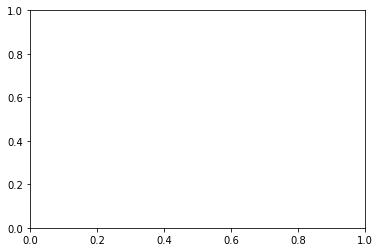

In [78]:
ticks = ['', 'Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End']

fig, ax = plt.subplots()
xdf2.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
ax.set_yticklabels(ticks)
plt.show()

# Testing

In [14]:
# event = {"data": {
#          "hdf": "/projects/APSDataAnalysis/Automate/A001_Aerogel2/A001_Aerogel2.hdf",
#          "imm": "/projects/APSDataAnalysis/Automate/A001_Aerogel2/A001_Aerogel2.imm",
# #          "flags": "--rigaku",     
#          "metadata": "/projects/APSDataAnalysis/Automate/A001_Aerogel2/A001_Aerogel2.json"      
#      }}
print(event)
# res = fxc.run(event, endpoint_id=theta_ep, function_id=alcf_xpcs_corr_func_uuid)
res = fxc.run(event, endpoint_id=theta_30_ep, function_id=alcf_xpcs_corr_func_uuid)

{'data': {'hdf': '/projects/APSDataAnalysis/Automate/test/test.hdf', 'imm': '/projects/APSDataAnalysis/Automate/test/test.imm', 'metadata': '/projects/APSDataAnalysis/Automate/test/test.json'}}


In [20]:
res
fxc.get_task_status(res)

{'completion_t': 1579637040.204562,
 'result': '01\ngANYBwMAAGInWzIwMjAtMDEtMjEgMjA6MDE6NDAuMjY4XSBbY29uc29sZV0gW2luZm9dIEg1IG1l\ndGFkYXRhIHBhdGggL3hwY3NcblsyMDIwLTAxLTIxIDIwOjAxOjQwLjY4NF0gW2NvbnNvbGVdIFtp\nbmZvXSBCdWlsZFFNYXAoKSB0b29rIDE4OSBtc1xuWzIwMjAtMDEtMjEgMjA6MDE6NDAuNjg2XSBb\nY29uc29sZV0gW2luZm9dIENvbmZpZ3VyYXRpb24gVG90YWwgdG9vayA0MDQgbXNcblsyMDIwLTAx\nLTIxIDIwOjAxOjQwLjY4Nl0gW2NvbnNvbGVdIFtpbmZvXSBQcm9jZXNzaW5nIElNTSBmaWxlIGF0\nIHBhdGggL3Byb2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS90ZXN0L3Rlc3QuaW1tLi5c\nblsyMDIwLTAxLTIxIDIwOjAxOjQwLjY4N10gW2NvbnNvbGVdIFtpbmZvXSBGaWxlIHNpemUgMzIy\nLjc0IE1ieXRlc1xuWzIwMjAtMDEtMjEgMjA6MDE6NDAuNjg3XSBbY29uc29sZV0gW2luZm9dIERh\ndGEgZnJhbWVzPTc2NyBzdHJpZGU9MSBhdmVyYWdlPTFcblsyMDIwLTAxLTIxIDIwOjAyOjE0LjQz\nM10gW2NvbnNvbGVdIFtpbmZvXSBMb2FkaW5nIGRhdGEgdG9vayAzMy4xMjIgc1xuWzIwMjAtMDEt\nMjEgMjA6MDM6NTEuMjQ0XSBbY29uc29sZV0gW2luZm9dIENvbXB1dGluZyBHMiBNdWx0aVRhdSB0\nb29rIDEuNjEyNjUgbVxuWzIwMjAtMDEtMjEgMjA6MDQ6MDAuMDA0XSBbY29uc29sZV0gW2luZm9d\nIE5vcm1hbGl6

In [21]:
fxc.get_result(res)

Exception: Task pending

In [46]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_00001-00400.imm",
#          "flags": "--rigaku",     
         "metadata": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400.json"      
     }}

0.0.1a2


In [9]:
res = fxc.run(event, endpoint_id=login_ep, function_id=pilot_func_uuid)



In [10]:
res

'ec7c696a-dfcc-4c70-8bbd-96036b7dac6a'

In [11]:
fxc.get_result(res)

"b'Uploading A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400 using globus... \\n'"

### Testing Pilot ingest

Need to figure out either using -s or renaming the directory the data is being processed in. Perhaps easiest if we just force everything to be worked on in the experiment name dir? then do a chdir to that exp?

In [34]:
def alcf_xpcs_pilot(event):
    import os
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Pilot")
    
    meta_file = event['data']['metadata']
    exp_dir = "/".join(event['data']['hdf'].split("/")[:-1])
    exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")
    
    os.chdir(exp_dir)
    
    pilot = '/home/rchard/.conda/envs/funcx-theta/bin/pilot'

    cmd = f"{pilot} upload -u -j {meta_file} {exp_name} /"
    print(cmd)
    return cmd
    res = subprocess.run(cmd.split(" "), stdout=PIPE, stderr=PIPE,
    env={'LC_ALL': 'C.UTF-8', 'LANG': 'C.UTF-8'})
    
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

4f63f171-a154-4a02-98a1-3d27551017a4


In [79]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_0001-0256.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_00001-00256.imm",
         "metadata": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_0001-0256.json"
     }}
res = fxc.run(event, endpoint_id=login_ep, function_id=pilot_func_uuid)
print(res)

8ef2d684-3fb6-4beb-864b-876051e94dd9


In [82]:
print(fxc.get_result(res))

Exception: Task pending

In [181]:
from funcx.serialize import FuncXSerializer
fx_serializer = FuncXSerializer()
res = """01\ngANYBgMAAGInWzIwMjAtMDEtMjIgMDA6MjI6MzEuNDE2XSBbY29uc29sZV0gW2luZm9dIEg1IG1l\ndGFkYXRhIHBhdGggL3hwY3NcblsyMDIwLTAxLTIyIDAwOjIyOjMxLjk0Nl0gW2NvbnNvbGVdIFtp\nbmZvXSBCdWlsZFFNYXAoKSB0b29rIDE3OSBtc1xuWzIwMjAtMDEtMjIgMDA6MjI6MzEuOTQ4XSBb\nY29uc29sZV0gW2luZm9dIENvbmZpZ3VyYXRpb24gVG90YWwgdG9vayA1MzEgbXNcblsyMDIwLTAx\nLTIyIDAwOjIyOjMxLjk0OF0gW2NvbnNvbGVdIFtpbmZvXSBQcm9jZXNzaW5nIElNTSBmaWxlIGF0\nIHBhdGggL3Byb2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS90ZXN0L3Rlc3QuaW1tLi5c\nblsyMDIwLTAxLTIyIDAwOjIyOjMxLjk1MF0gW2NvbnNvbGVdIFtpbmZvXSBGaWxlIHNpemUgMTc1\nLjY2NCBNYnl0ZXNcblsyMDIwLTAxLTIyIDAwOjIyOjMxLjk1MF0gW2NvbnNvbGVdIFtpbmZvXSBE\nYXRhIGZyYW1lcz0zOTkgc3RyaWRlPTEgYXZlcmFnZT0xXG5bMjAyMC0wMS0yMiAwMDoyMjo0OS42\nNDldIFtjb25zb2xlXSBbaW5mb10gTG9hZGluZyBkYXRhIHRvb2sgMTcuMDQ0IHNcblsyMDIwLTAx\nLTIyIDAwOjIzOjQwLjY0N10gW2NvbnNvbGVdIFtpbmZvXSBDb21wdXRpbmcgRzIgTXVsdGlUYXUg\ndG9vayA1MC45NDYgc1xuWzIwMjAtMDEtMjIgMDA6MjM6NDguODc3XSBbY29uc29sZV0gW2luZm9d\nIE5vcm1hbGl6aW5nIERhdGEgdG9vayA4LjIzIHNcblsyMDIwLTAxLTIyIDAwOjIzOjQ4Ljg3N10g\nW2NvbnNvbGVdIFtpbmZvXSBUb3RhbCB0b29rIDEuMjkxMDIgbVxuJ3EALg==\n"""

x = fx_serializer.deserialize(res)
x


"b'[2020-01-22 00:22:31.416] [console] [info] H5 metadata path /xpcs\\n[2020-01-22 00:22:31.946] [console] [info] BuildQMap() took 179 ms\\n[2020-01-22 00:22:31.948] [console] [info] Configuration Total took 531 ms\\n[2020-01-22 00:22:31.948] [console] [info] Processing IMM file at path /projects/APSDataAnalysis/Automate/test/test.imm..\\n[2020-01-22 00:22:31.950] [console] [info] File size 175.664 Mbytes\\n[2020-01-22 00:22:31.950] [console] [info] Data frames=399 stride=1 average=1\\n[2020-01-22 00:22:49.649] [console] [info] Loading data took 17.044 s\\n[2020-01-22 00:23:40.647] [console] [info] Computing G2 MultiTau took 50.946 s\\n[2020-01-22 00:23:48.877] [console] [info] Normalizing Data took 8.23 s\\n[2020-01-22 00:23:48.877] [console] [info] Total took 1.29102 m\\n'"

In [172]:
fx_serializer.unpack_and_deserialize(res)


Exception: Invalid header: g in data payload

### Nick testing

In [ ]:
def process_hdf(event):
    import os
    import shutil
    from XPCS.scripts.xpcs_metadata import gather
    from XPCS.scripts.xpcs_plots import make_plots
    from XPCS.scripts.xpcs_qc import check_hdf_dataset
    from pilot.client import PilotClient

    hdf_file = event['data']['hdf']
    hdf_dir, extension = os.path.splitext(hdf_file)
    try:
        os.mkdir(hdf_dir)
        shutil.move(hdf_file, hdf_dir)
    except Exception as e:
        print(e)
    hdf_file = os.path.join(hdf_dir, os.path.basename(hdf_file))
    os.chdir(hdf_dir)
    assert os.path.exists(hdf_file), 'HDF File {hdf_file} does not exist!'

    if check_hdf_dataset(hdf_file) is False:
        print('HDF Check failed, skipping...')
        return {}
    metadata = gather(hdf_file)
    make_plots(hdf_file)
    metadata.update(event['custom_metadata'])
    pc = PilotClient()
    uploaded_metadata = pc.register(hdf_dir, '/', metadata=metadata,
                                    update=True, skip_analysis=True)
    print('Everything worked, register called')
    return uploaded_metadata

In [ ]:
process_hdf_func_uuid = fxc.register_function(
    process_hdf, description="Put hdf file into dir, make plots, gather metadata."
)
print(process_hdf_func_uuid)

In [ ]:
fname = '/Users/nick/globus/aps/globus-automation/XPCS/data/A001_Aerogel_1mm_att3_Lq0_001_0001-1000.hdf'
payload = {
    'data': {
        "hdf": f"{fname}"
    },
    'custom_metadata': {
        "description": f"{fname}: Automated data processing.",
        "creators": [{"creatorName": "8-ID"}],
        "publisher": "Automate",
        "title": fname,
        "subjects": [{"subject": "XPCS"}, {"subject": "8-ID"}],
        "publicationYear": "2019",
        "resourceType": {
            "resourceType": "Dataset",
            "resourceTypeGeneral": "Dataset"
        }
    }
}
res = fxc.run(payload, endpoint_id=local_ep, function_id=process_hdf_func_uuid)
print(res)

In [ ]:
print(res)
fxc.get_result(res)

In [ ]:
# This flow does not return the result to APS.

flow_definition = {
  "Comment": "Automate XPCS",
  "StartAt": "Transfer1",
  "States": {
    "Transfer1": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer1Input",
      "ResultPath": "$.Transfer1Result",
      "WaitTime": 6000,
      "Next": "ExecCorr"
    },
    "ExecCorr": {
      "Comment": "Use corr to process the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 12000,
      "Next": "ExecPlots"
    },
    "ExecPlots": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec2Input",
      "ResultPath": "$.Exec2Result",
      "WaitTime": 12000,
      "Next": "ExecPilot"
    },
    "ExecPilot": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec3Input",
      "ResultPath": "$.Exec3Result",
      "WaitTime": 12000,
      "Next": "Transfer2"
    },
    "Transfer2": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer2Input",
      "ResultPath": "$.Transfer2Result",
      "WaitTime": 6000,
      "End": True
    }
  }
}